<div>
    <img src="images/emlyon.png" style="height:60px; float:left; padding-right:10px; margin-top:5px" />
    <span>
        <h1 style="padding-bottom:5px;"> Introduction to Deep Learning </h1>
        <a href="https://masters.em-lyon.com/fr/msc-in-data-science-artificial-intelligence-strategy">[DSAIS]</a> MSc in Data Science & Artificial Intelligence Strategy <br/>
         Paris | © Saeed VARASTEH
    </span>
</div>

<div class="alert-info" style="border-bottom: solid 1px lightgray; background-color:#fff4e3;">
    <img src="images/homework.png" style="height:60px; float:left; padding-right:10px;" />
    <span style="font-weight:bold; color:#db9425">
        <h4 style="padding-top:25px;"> HOMEWORK 03 </h4>
    </span>
</div>

### Homework 03 - Sentiment Analysis

<img style="width:20%" src="./images/sentiment-analysis.jpg" />

In this assignment, you'll be working with the Amazon Customer Reviews dataset. This dataset consists of 4 million Amazon customer reviews. You are going to build a sentiment classification model on this dataset.

Our goal at this implementation will be to create a multi-layered LSTM model that can accurately classify and distinguish the sentiment of a review.

You can run the codes on a GPU to speed up the training process.

Here are the steps you need to follow:

__Step 1: Data Preprocessing__

I helped you with this step! Data loading, preprocessing, and tokenization. 

Follow my code and do what I have asked you to do. You can use the functions and code we used in class.

__Step 2: PyTorch Dataset and DataLoaders__

Create the PyTorch datasets and dataloaders as we did in class.

__Step 3: Building the Model__

Build a multi-layered LSTM model, (be creative), and add any classifier head on top of it.

__Step 4: Model Training and Evaluation__

Train the model and validate it using the validation set.

__Step 5: Model Testing__

Compute and report your accuracy on the test dataset.

<div class="alert-danger">
Do not use any online resources to complete this assignment. You have been given everything you need to complete this assignment.
</div>

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

np.random.seed(72) # DO NOT CHANGE THIS
torch.manual_seed(72) # DO NOT CHANGE THIS

---

In [2]:
# Setup device automatically
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

---

### Data

#### Getting data

As the data is compressed in the bz2 format, we'll use the Python bz2 module to read the data

In [3]:
import bz2
# Be patient, this step takes a long time to execute.
train_file_all = bz2.BZ2File("./data/AmazonReviews/train.ft.txt.bz2").readlines()
test_file_all = bz2.BZ2File("./data/AmazonReviews/test.ft.txt.bz2").readlines()

print('Done')

Done


In [4]:
print("Number of training reivews: " + str(len(train_file_all)))
print("Number of test reviews: " + str(len(test_file_all)))

Number of training reivews: 3600000
Number of test reviews: 400000


This dataset contains a total of 4 million reviews - 3.6 million training and 0.4 million testing. We won't be using the entire dataset to save time.

In [5]:
import random
random.seed(72) # DO NOT CHANGE THIS

num_train = 10000 # DO NOT CHANGE THIS
num_test = 500 # DO NOT CHANGE THIS

train_file = [x.decode("utf-8") for x in random.sample(train_file_all, num_train)]
test_file = [x.decode("utf-8") for x in random.sample(test_file_all, num_test)]

In [6]:
print("Number of training reivews: " + str(len(train_file)))
print("Number of test reviews: " + str(len(test_file)))

Number of training reivews: 10000
Number of test reviews: 500


Some examples:

<img style="width:70%" src="data/AmazonReviews/screenshots/one.png" />

In [7]:
train_file[0]

"__label__1 Toxins: On the back of this product it states that it has a chemical in it known to the state of California to cause cancer. I wouldn't have purchased it if I had know this. It cost half the price of the product to ship it back to Amazon so it was hardly worth it.\n"

In [8]:
train_file[3]

'__label__2 Great way to remember some of the best classics: If you played all this games at the arcade, you will surely like this game.Still, new comers might find it not so appealing.\n'

### Data preprocessing

#### Extracting labels from sentences

As you can see, each sentence starts with a \_\_label\_\_1/2 and then the review itself. You need to extract these labels from the sentences.

__Note:__ Positive reviews are labeled as \_\_label\_\_2 and negative reviews are labeled as _\_label\_\_1.

Create training and test labels where positive labels are converted to 1 and negative labels are converted to 0.

Create training and test reviews as review text.

In [9]:
def extract_text_label(line):
    parts = line.split(' ', 1)
    label = 1 if parts[0] == "__label__2" else 0
    text = parts[1]
    return label, text

In [10]:
train_labels, train_reviews = zip(*[extract_text_label(line) for line in train_file])

test_labels, test_reviews = zip(*[extract_text_label(line) for line in test_file])

Desired outputs:

<img style="width:70%" src="data/AmazonReviews/screenshots/two.png" />

In [11]:
train_reviews[0]

"Toxins: On the back of this product it states that it has a chemical in it known to the state of California to cause cancer. I wouldn't have purchased it if I had know this. It cost half the price of the product to ship it back to Amazon so it was hardly worth it.\n"

In [12]:
train_labels[0]

0

In [13]:
train_reviews[3]

'Great way to remember some of the best classics: If you played all this games at the arcade, you will surely like this game.Still, new comers might find it not so appealing.\n'

In [14]:
train_labels[3]

1

#### Tokenization and the Vocabulary

Bring the the `clean_word()` function here:

In [15]:
import re

def clean_word(word):
    return re.sub("[^a-z0-9]","", word.lower())
    # return re.sub(f'[{string.punctuation}]','', word.lower())

Extract all tokens from the __train_reviews__, clean them and save them as __words__ list, but __do not remove duplicates__. 

In [16]:
# your code
words = " ".join(train_reviews).split(' ')
words = [clean_word(w) for w in words]
# words = list(filter(None, words))
len(words)

780429

Remove tokens from the __words__ that only appear once:

There are many ways to do this. I leave it up to you to find a good way.

<span style="color:crimson">Tip:</span> Using `Counter` from the `collections` library might help a lot!

In [17]:
# your code
from collections import Counter
words_counters = Counter(words)
words_filtered = [words for words in words_counters if words_counters[words] > 1]
words_filtered

['toxins',
 'on',
 'the',
 'back',
 'of',
 'this',
 'product',
 'it',
 'states',
 'that',
 'has',
 'a',
 'chemical',
 'in',
 'known',
 'to',
 'state',
 'california',
 'cause',
 'cancer',
 'i',
 'wouldnt',
 'have',
 'purchased',
 'if',
 'had',
 'know',
 'cost',
 'half',
 'price',
 'ship',
 'amazon',
 'so',
 'was',
 'hardly',
 'worth',
 'bad',
 'tuner',
 'you',
 'ever',
 'plan',
 'listen',
 'radio',
 'dont',
 'purchase',
 'stereo',
 'is',
 'analog',
 'and',
 'difficulty',
 'staying',
 'selected',
 'station',
 'also',
 'there',
 'are',
 'no',
 'preset',
 'stations',
 'zero',
 'stars',
 'for',
 'boss',
 'but',
 'five',
 'taking',
 'disappointing',
 'great',
 'emergent',
 'readers',
 'even',
 'students',
 'love',
 'entire',
 'series',
 'children',
 'who',
 'all',
 'ages',
 'really',
 'gets',
 'them',
 'going',
 'they',
 'tend',
 'find',
 'an',
 'enjoyment',
 'reading',
 'way',
 'remember',
 'some',
 'best',
 'classics',
 'played',
 'games',
 'at',
 'arcade',
 'will',
 'surely',
 'like',
 'n

Remove duplicates from __words__:

In [18]:
words_filtered = np.unique(words_filtered)

If you have done everything correctly, you should have ~18000 unique words in your vocabulary.

In [19]:
len(words_filtered)

18066

#### Building word2idx dictionary

To account for padding, we add '_PAD' to our vocabulary:

In [20]:
word2idx = {}
word2idx["_PAD"] = 0

Finally, each word in the vocabulary will then be assigned an integer index. Complete __word2idx__ dictionary.

In [21]:
# your code
for i,w in enumerate(words_filtered):
    word2idx[w] = i+1

len(word2idx)

18067

In [22]:
len(word2idx)

18067

#### Convert sentences

Bring the the `sent2inds()` function here:

In [23]:
# your code

def sent2inds(in_):
    in_ = in_.split()

    out_ = []

    for w in in_:
        w = clean_word(w)
        if w != "" and w in word2idx.keys():
            out_.append(word2idx[w])
    return out_

Convert the words in the reviews to their corresponding indices from the vocabulary:

Name the outputs as __train_reviews_encoded__ and __test_reviews_encoded__.

In [24]:
train_reviews_encoded = pd.Series(train_reviews).apply(sent2inds)
# your code

test_reviews_encoded = pd.Series(test_reviews).apply(sent2inds)
# your code


Desired outputs:

<img style="width:70%" src="data/AmazonReviews/screenshots/three.png" />

In [25]:
print( train_reviews[0] )

Toxins: On the back of this product it states that it has a chemical in it known to the state of California to cause cancer. I wouldn't have purchased it if I had know this. It cost half the price of the product to ship it back to Amazon so it was hardly worth it.



In [26]:
print( train_reviews_encoded[0] )

[16456, 11099, 16071, 1478, 11017, 16154, 12362, 8520, 15229, 16066, 8520, 7390, 391, 2899, 8075, 8520, 8977, 16321, 16071, 15224, 11017, 2506, 16321, 2723, 2548, 7924, 17863, 7421, 12576, 8520, 7965, 7924, 7253, 8971, 16154, 8520, 3761, 7265, 16071, 12285, 11017, 16071, 12362, 16321, 14357, 8520, 1478, 16321, 890, 14799, 8520, 17451, 7350, 17857, 8520]


#### Paddings

Fill the records in __train_reviews_encoded__ and __test_reviews_encoded__ with 0s, if needed.

We want to fix the input lengths to 200. 

__If the length is greater than 200, just keep the last 200 tokens, if the length is less than 200, add zeros to the beginning of the token list.__

<span style="color:crimson">Tip:</span> You can use the `np.pad()` function to do this.

Name the output lists as __X_train__ and __X_test__.

In [27]:
def pad_sequence(seq, desired_length=200):
    """
    Pads or trims a sequence to a desired length.
    
    Args:
    seq: List of tokens (integers).
    desired_length: The length to pad or trim the sequence to.
    
    Returns:
    A new sequence with the desired length.
    """
    current_length = len(seq)
    
    if current_length > desired_length:
        # Keep the last `desired_length` tokens
        return seq[-desired_length:]
    elif current_length < desired_length:
        # Calculate the number of zeros needed to prepend
        padding_length = desired_length - current_length
        # Pad with zeros at the beginning
        return np.pad(seq, (padding_length, 0), mode='constant', constant_values=0).tolist()
    else:
        # Return the sequence as is if it's already the desired length
        return seq

X_train = [pad_sequence(review) for review in train_reviews_encoded]
# your code

X_test = [pad_sequence(review) for review in test_reviews_encoded]
# your code


Desired outputs:

<img style="width:70%" src="data/AmazonReviews/screenshots/four.png" />

In [28]:
print( train_reviews_encoded[0] )

[16456, 11099, 16071, 1478, 11017, 16154, 12362, 8520, 15229, 16066, 8520, 7390, 391, 2899, 8075, 8520, 8977, 16321, 16071, 15224, 11017, 2506, 16321, 2723, 2548, 7924, 17863, 7421, 12576, 8520, 7965, 7924, 7253, 8971, 16154, 8520, 3761, 7265, 16071, 12285, 11017, 16071, 12362, 16321, 14357, 8520, 1478, 16321, 890, 14799, 8520, 17451, 7350, 17857, 8520]


In [29]:
print( X_train[0] )

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16456, 11099, 16071, 1478, 11017, 16154, 12362, 8520, 15229, 16066, 8520, 7390, 391, 2899, 8075, 8520, 8977, 16321, 16071, 15224, 11017, 2506, 16321, 2723, 2548, 7924, 17863, 7421, 12576, 8520, 7965, 7924, 7253, 8971, 16154, 8520, 3761, 7265, 16071, 12285, 11017, 16071, 12362, 16321, 14357, 8520, 1478, 16321, 890, 14799, 8520, 17451, 7350, 17857, 8520]


#### To Numpys

Convert the lists to Numpy arrays if you have not already done so. 

Check __X_train__ and __X_test__ dimensions.

In [30]:
X_train = np.array(X_train)
X_train.shape # (10000, 200)

(10000, 200)

In [31]:
X_test = np.array(X_test)
X_test.shape # (500, 200)

(500, 200)

#### Labels

Converting the labels into numpy arrays.

In [32]:
y_train = np.array(train_labels)
y_train.shape # (10000,)

(10000,)

In [33]:
y_test = np.array(test_labels)
y_test.shape # (500,)

(500,)

__Well done! we are ready to train the model!__

---

### Dataset

In [34]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).long()
        self.labels = torch.from_numpy(labels).float()
        
    def __getitem__(self, index):
        return (self.data[index], self.labels[index])

    def __len__(self):
        return len(self.data)
    
train_dataset = MyDataset(X_train, y_train)

### Train/Validation Split

In [35]:
train_dataset, val_dataset = random_split(train_dataset, [8000, 2000])

### DataLoaders

In [36]:
train_loader = DataLoader(dataset=train_dataset, batch_size=100)
val_loader = DataLoader(dataset=val_dataset, batch_size=100)

### Building a Model (Multi-layered RNN)

Build a multilayer LSTM with 2 layers and 32 hidden units.

<img style="width:60%" src="./images/rnn_layered.png" />

In [38]:
# model
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.emb = nn.Embedding(len(word2idx), 50)
        self.rnn = nn.RNN(input_size=50, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32,1)

    
    def forward(self, x):
        
        out = self.emb(x)
        h0 = torch.zeros(1, x.size(0), 32)
        outs, hidden = self.rnn(out)
        # out = outs[:,-1,:]
        
        # out = torch.max(outs, 1)
        out, _ = torch.max(outs, 1)

        out  = self.fc(out)
        return out
    

# class MyModel(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         self.emb = nn.Embedding(len(word2idx), 50)
#         self.rnn = nn.RNN(input_size=50, hidden_size=32, num_layers=2, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(32 * 2, 1)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         out = self.dropout(self.emb(x))
#         h0 = torch.zeros(2 * 2, x.size(0), 32)
#         outs, hidden = self.rnn(out, h0)
#         out, _ = torch.max(outs, 1)
#         out = self.dropout(out)
#         out = self.fc(out)
#         return out

Accuracy function:

In [39]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

### Model Training

In [40]:
from timeit import default_timer as timer 
start_time = timer() # timer start

model = MyModel().to(device)

train_losses = []; train_accs = []
validation_losses = []; validation_accs = []

lr = 0.001
n_epochs = 30

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

###
patience = 5
patience_counter = 0
best_val_loss = float('inf')
###

for epoch in range(n_epochs):
    # Training Loop
    model.train()
    train_loss, train_acc = 0, 0
    
    for x_batch, y_batch in train_loader: 
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_logits = model(x_batch).squeeze() # squeeze to remove extra `1` dimensions,
        loss = loss_fn(y_logits, y_batch)
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
        train_acc += accuracy_fn(y_true=y_batch, y_pred=y_pred) 
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_acc /= len(train_loader)
    train_accs.append(train_acc)
    
    # Validation Loop
    model.eval()
    validation_loss , validation_acc = 0, 0
    
    with torch.no_grad():
        for x_val, y_val in val_loader:

            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_logits = model(x_val).squeeze()
            val_loss = loss_fn(y_logits, y_val)
            
            validation_loss += val_loss.item()
            
            y_pred = torch.round(torch.sigmoid(y_logits)) 
            validation_acc += accuracy_fn(y_true=y_val, y_pred=y_pred) 
        
    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss)
    
    validation_acc /= len(val_loader)
    validation_accs.append(validation_acc)
    
    # Print out what's happening, every epoch
    if (epoch+1) % 1 == 0:
        print(f"Epoch: {epoch+1} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | val loss: {validation_loss:.5f}, val acc: {validation_acc:.2f}%")

    ###
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Stopping early at epoch {epoch+1} due to no improvement in validation loss.")
        break
    ###
    
end_time = timer() # timer end
total_time = end_time - start_time
print(f"Train time on {device}: {total_time:.3f} seconds")

Epoch: 1 | Loss: 0.71513, Accuracy: 51.21% | val loss: 0.68848, val acc: 58.05%
Epoch: 2 | Loss: 0.70278, Accuracy: 51.42% | val loss: 0.68224, val acc: 58.65%
Epoch: 3 | Loss: 0.68629, Accuracy: 54.50% | val loss: 0.66133, val acc: 61.70%
Epoch: 4 | Loss: 0.65229, Accuracy: 62.34% | val loss: 0.62020, val acc: 63.40%
Epoch: 5 | Loss: 0.62252, Accuracy: 65.65% | val loss: 0.58094, val acc: 69.45%
Epoch: 6 | Loss: 0.59035, Accuracy: 68.90% | val loss: 0.57001, val acc: 70.10%
Epoch: 7 | Loss: 0.55236, Accuracy: 72.12% | val loss: 0.52039, val acc: 74.60%
Epoch: 8 | Loss: 0.53058, Accuracy: 73.72% | val loss: 0.50675, val acc: 75.80%
Epoch: 9 | Loss: 0.49965, Accuracy: 75.97% | val loss: 0.47097, val acc: 78.45%
Epoch: 10 | Loss: 0.47434, Accuracy: 77.03% | val loss: 0.44714, val acc: 79.75%
Epoch: 11 | Loss: 0.44015, Accuracy: 79.39% | val loss: 0.42133, val acc: 79.75%
Epoch: 12 | Loss: 0.43316, Accuracy: 79.96% | val loss: 0.40503, val acc: 81.50%
Epoch: 13 | Loss: 0.40212, Accuracy: 

Learning curves:

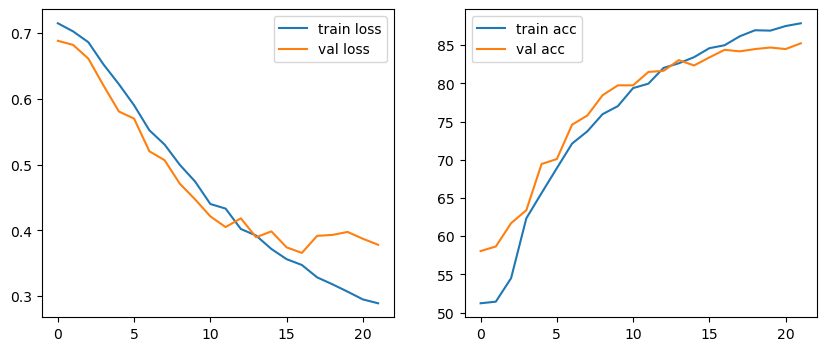

In [41]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(train_losses,  label="train loss"); 
ax[0].plot(validation_losses,  label="val loss"); 
ax[0].legend();

ax[1].plot(train_accs,  label="train acc");
ax[1].plot(validation_accs,  label="val acc"); 
ax[1].legend();

### Making Predications

In [42]:
class MyDataset2(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).long()
        self.labels = torch.from_numpy(labels).float()
        
    def __getitem__(self, index):
        return (self.data[index], self.labels[index])

    def __len__(self):
        return len(self.data)
    
test_dataset = MyDataset2(X_test, y_test)

In [43]:
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

In [44]:
# Test Loop
model.eval()
test_acc = 0

# your code

with torch.no_grad():
    for x_test, y_test in test_loader:

        x_test = x_test.to(device)
        y_test = y_test.to(device).squeeze()

        yhat = model(x_test)
        yhat = yhat.view(-1)
        yhat = torch.sigmoid(yhat).round()
        acc = accuracy_fn(y_test, yhat)
        
        test_acc += acc
        

test_acc /= len(test_loader)


print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 85.20%


---